In [1]:
import pyspark as ps
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf, array
from pyspark.sql.types import StringType
from pyspark.sql.functions import col
from pyspark.sql.functions import countDistinct
import matplotlib.pyplot as plt
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("nathanscope") 
        .getOrCreate()
        )

In [2]:
sc = spark.sparkContext

In [3]:
def auth_casting_function(row):
    (time, scr_user, dst_user, src_comp, dst_comp, auth_type,logon_type,auth_orientation,success) = row
    feilds = [time, scr_user, dst_user, src_comp, dst_comp, auth_type,logon_type,auth_orientation,success]
    
    print('success')
    if(time=='?'):
        time = 666999666
    return (int(time),scr_user, dst_user, src_comp, dst_comp, auth_type,logon_type,auth_orientation,success)

In [4]:
def proc_casting_function(row):
    (time,user_domain,comp,proc_name,start) = row
    if(time=='?'):
        time = 666999666
    return (int(time),user_domain,comp,proc_name,start)

In [5]:
def flow_casting_function(row):
    (time, duration,src_comp,src_port,dst_comp,dst_port,protocol,pk_count,byte_count) = row
    if(time=='?'):
        time = 666999666
    return (int(time),int(duration),src_comp,src_port,dst_comp,dst_port,protocol,int(pk_count),int(byte_count))

In [6]:
def DNS_casting_function(row):
    (time, src_comp,comp_resolved) = row
    if(time=='?'):
        time = 666999666
    return (int(time),src_comp,comp_resolved)

In [7]:
# import the many data types
from pyspark.sql.types import *

# create a schema of your own
auth_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('src_user_domain',   StringType(),  True),
    StructField('dst_user_domain',   StringType(),  True),
    StructField('src_comp',   StringType(),  True),
    StructField('dst_comp',   StringType(),  True),
    StructField('auth_type',  StringType(), True),
    StructField('logon_type',  StringType(),  True),
    StructField('auth_orientation',  StringType(),  True),
    StructField('Success',  StringType(),  True)] )

proc_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('user_domain',   StringType(),  True),
    StructField('comp',   StringType(),  True),
    StructField('proc_name',   StringType(),  True),
    StructField('start',   StringType(),  True),
    ] )

flow_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('duration',     LongType(), True),
    StructField('src_comp',   StringType(),  True),
    StructField('src_port',   StringType(),  True),
    StructField('dst_comp',   StringType(),  True),
    StructField('dst_port',   StringType(),  True),
    StructField('protocol',  StringType(), True),
    StructField('pk_count',  LongType(),  True),
    StructField('byte_count',  LongType(),  True)] )

DNS_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('src_comp',   StringType(),  True),
    StructField('comp_resolved',   StringType(),  True),
    
    ] )

## Create RDDS from Text Input

rdd_auth = (sc.pickleFile("Data/Day30/auth/part*")
            
           )

rdd_proc = (sc.pickleFile("Data/Day30/proc/part*")
            
           )

rdd_flow = (sc.pickleFile('Data/Day30/flow/part*')
           )

rdd_DNS = (sc.pickleFile("Data/Day30/DNS/part*")
           
           )

## Create DataFrames from RDDs and 

In [8]:
auth_df = spark.createDataFrame(rdd_auth,auth_schema)

proc_df = spark.createDataFrame(rdd_proc,proc_schema)

flow_df = spark.createDataFrame(rdd_flow,flow_schema)

DNS_df = spark.createDataFrame(rdd_DNS,DNS_schema)

In [9]:
active_comps_df = pd.read_csv('Summary/Day1/active_comps_df.csv')
active_user_df= pd.read_csv('Summary/Day1/active_users_df.csv')
active_red_team =pd.read_csv('Summary/Day1/active_red_team.csv')


In [10]:
red_30 = active_red_team[active_red_team['time']<2592000]

In [11]:
active_comps_df.columns = ['ignore','comp','count']

In [12]:
active_flow_df = flow_df.where(col("src_comp").isin(list(active_comps_df['comp'])) | col("dst_comp").isin(list(active_comps_df['comp'])))

red_flow_df = flow_df.where(col("src_comp").isin(list(active_red_team['dst_comp'])) | col("dst_comp").isin(list(active_red_team['dst_comp'])))




In [13]:
add_download = udf(lambda x : 1 if x in list(active_comps_df['comp']) else 0 )
add_upload = udf(lambda x : 1 if x in list(active_comps_df['comp']) else 0 )

In [14]:
active_flow_df = active_flow_df.withColumn('Download', add_download(active_flow_df['dst_comp']))
active_flow_df = active_flow_df.withColumn('Upload', add_upload(active_flow_df['src_comp']))

In [15]:
red_flow_df = red_flow_df.withColumn('Download', add_download(red_flow_df['dst_comp']))
red_flow_df = red_flow_df.withColumn('Upload', add_upload(red_flow_df['src_comp']))

In [16]:
add_count = udf(lambda x : x[1] if x[0]=='1' else 0 )

In [17]:
active_flow_df = active_flow_df.withColumn('upload_bytes',add_count(array('Upload','byte_count')))
active_flow_df = active_flow_df.withColumn('download_bytes',add_count(array('Download','byte_count')))
active_flow_df = active_flow_df.withColumn('upload_pk',add_count(array('Upload','pk_count')))
active_flow_df = active_flow_df.withColumn('download_pk',add_count(array('Download','pk_count')))

In [18]:
red_flow_df = red_flow_df.withColumn('upload_bytes',add_count(array('Upload','byte_count')))
red_flow_df = red_flow_df.withColumn('download_bytes',add_count(array('Download','byte_count')))
red_flow_df = red_flow_df.withColumn('upload_pk',add_count(array('Upload','pk_count')))
red_flow_df = red_flow_df.withColumn('download_pk',add_count(array('Download','pk_count')))

In [19]:
interval_size = 3600
make_interval = udf(lambda x :  (x//interval_size)*interval_size)

In [20]:
 active_flow_df = active_flow_df.withColumn('interval', make_interval(active_flow_df['time']))

In [21]:
red_flow_df = red_flow_df.withColumn('interval', make_interval(active_flow_df['time']))

In [22]:
flow_time_series = active_flow_df.groupBy('interval').agg({'duration': 'mean','pk_count':'sum','byte_count':'sum','upload_bytes':'sum','download_bytes':'sum','upload_pk':'sum','download_pk':'sum'}).collect()



In [23]:
red_flow_time_series = red_flow_df.groupBy('interval').agg({'duration': 'mean','pk_count':'sum','byte_count':'sum','upload_bytes':'sum','download_bytes':'sum','upload_pk':'sum','download_pk':'sum'}).collect()




In [24]:
flow_time_series_df = pd.DataFrame(flow_time_series)
flow_time_series_df.columns = ['time','mean_duration','pk_count','byte_count','upload_bytes','download_bytes','upload_pk','download_pk']
flow_time_series_df['time'] = flow_time_series_df['time'].astype('int64')
flow_time_series_df = flow_time_series_df.sort_values('time')

In [25]:
red_flow_time_series_df = pd.DataFrame(red_flow_time_series)
red_flow_time_series_df.columns = ['time','mean_duration','pk_count','byte_count','upload_bytes','download_bytes','upload_pk','download_pk']
red_flow_time_series_df['time'] = red_flow_time_series_df['time'].astype('int64')
red_flow_time_series_df = red_flow_time_series_df.sort_values('time')


In [26]:
red_flow_time_series_df

,time,mean_duration,pk_count,byte_count,upload_bytes,download_bytes,upload_pk,download_pk
68,0,21.596330,3462598,208190.0,2639.0,5594,3254408.0,2955.0
89,3600,20.128713,183634,138742.0,194.0,424,44892.0,230.0
252,7200,20.242424,54065,16973.0,99.0,258,37092.0,159.0
350,10800,20.326531,52699,16927.0,98.0,273,35772.0,175.0
34,14400,16.168478,8030815,7893442.0,5658.0,6880,137373.0,1222.0
288,18000,28.248447,15699323,370881.0,5897.0,19415,15328442.0,13518.0
137,21600,20.401961,197701966,193898974.0,129846.0,205044,3802992.0,75198.0
11,25200,18.358974,30977211,396964.0,1281.0,25440,30580247.0,24159.0
59,28800,17.565217,273106,109637.0,476.0,881,163469.0,405.0
123,32400,34.738854,4122730,600755.0,4127.0,15298,3521975.0,11171.0


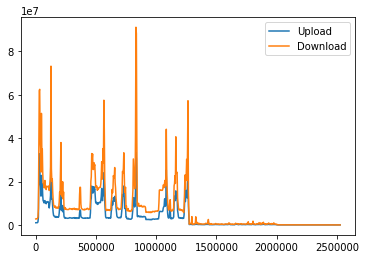

In [27]:
plt.plot(flow_time_series_df['time'],flow_time_series_df['upload_bytes'],label = 'Upload')
plt.plot(flow_time_series_df['time'],flow_time_series_df['download_bytes'],label = 'Download')
plt.legend()

(1, 5)

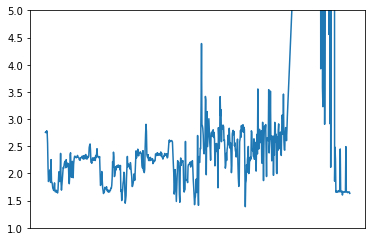

In [28]:
plt.plot(flow_time_series_df['time'],flow_time_series_df['download_bytes']/flow_time_series_df['upload_bytes'])
plt.xticks([], [])
plt.ylim([1,5])



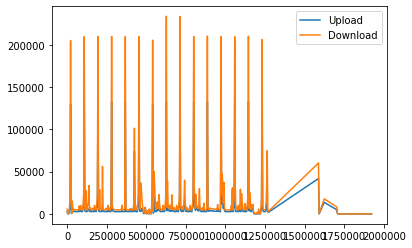

In [29]:
plt.plot(red_flow_time_series_df['time'],red_flow_time_series_df['upload_bytes'],label = 'Upload')
plt.plot(red_flow_time_series_df['time'],red_flow_time_series_df['download_bytes'],label = 'Download')
#plt.scatter(red_30['time'],[0]*36)

#for comp_time in red_30['time']:




plt.legend()

([], <a list of 0 Text xticklabel objects>)

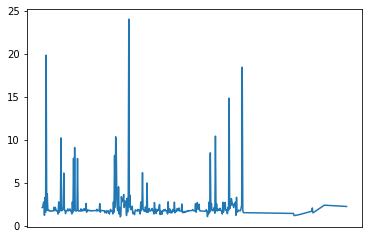

In [30]:
plt.plot(red_flow_time_series_df['time'],red_flow_time_series_df['download_bytes']/red_flow_time_series_df['upload_bytes'])
plt.xticks([], [])





153792
155219
483455
483981
485925
486443
491747
736894
755904
757235
760807
764522
766150
767238
774180
1074182
1075605
1075609
1075721
1077140
1079926
1100031
1167994
1174646
1177987
1178267
1179228
1179553
1179589
1244695
1246511
1246653
1358383
1358404
1361921
1362045


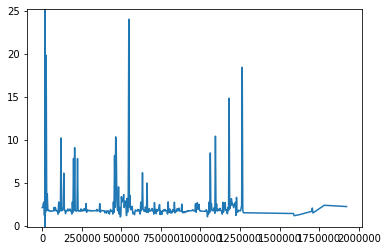

In [31]:
fig, ax = plt.subplots()
ax.plot(red_flow_time_series_df['time'].astype('int64'),red_flow_time_series_df['download_bytes'].astype('int64')/red_flow_time_series_df['upload_bytes'].astype('int64'))

for comp in red_30['time'].astype('int64'):
    print(comp)
    ax.axvline(20000)


In [32]:
max(red_flow_time_series_df['time'].astype('int64'))

1922400